# 0. Getting setup

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine


In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# 1. Get data

In [7]:
# The data is already downloaded - Check the download_data.py

# 2. Create Datasets and DataLoaders

## 2.1 Create DataLoaders using manually created transforms

In [8]:
from pathlib import Path

# Setup directories
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x1043c9d90>,
 ['pizza', 'steak', 'sushi'])

## 2.2 Create DataLoaders using automatically created transforms

In [9]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1043c9c70>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [10]:
# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup the the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

set_seeds() # Since we are creating a new layer with random weights

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True)).to(device)

In [12]:
from torchinfo import summary

# # Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# 4. Train model and track results

In [13]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [16]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [17]:
# Train model
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9756 | train_acc: 0.5437 | test_loss: 0.6656 | test_acc: 0.8909
Epoch: 2 | train_loss: 0.6917 | train_acc: 0.8187 | test_loss: 0.5422 | test_acc: 0.8909
Epoch: 3 | train_loss: 0.5774 | train_acc: 0.8167 | test_loss: 0.4718 | test_acc: 0.8847
Epoch: 4 | train_loss: 0.4934 | train_acc: 0.8688 | test_loss: 0.4307 | test_acc: 0.9131
Epoch: 5 | train_loss: 0.4426 | train_acc: 0.8646 | test_loss: 0.3877 | test_acc: 0.8977


In [18]:
# Check the model results
results

{'train_loss': [0.9755731542905172,
  0.6916859825452168,
  0.5774039924144745,
  0.49337825576464334,
  0.4425999840100606],
 'train_acc': [0.54375,
  0.81875,
  0.8166666666666667,
  0.86875,
  0.8645833333333334],
 'test_loss': [0.6655783653259277,
  0.5421805799007415,
  0.4718221664428711,
  0.4306855916976929,
  0.3876979470252991],
 'test_acc': [0.890909090909091,
  0.890909090909091,
  0.884659090909091,
  0.9130681818181818,
  0.8977272727272727]}

# 5. View out model's results in TensorBoard

**In VC Code:** Press `SHIFT + CMD + P` to open the Command Palette and search for the command "Python: Launch TensorBoard".

# 6. Create a helper function to build `SummaryWriter()` instances

For example we'd like to track things like:
- **Experiment date/timestamp** - when did the experiment take place?
- **Experiment name** - is there something we'd like to call the experiment?
- **Model name** - what model was used?
- **Extra** - should anything else be tracked?

In [19]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on the same day will be in the same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format
    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [20]:
# Create an example writer
example_writer = create_writer(experiment_name="data_20_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2023-08-31/data_20_percent/effnetb0/5_epochs...


## 6.1 Update the `train()` function to include a `writer()` parameter

In [21]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

# 7. Setting up a series of modelling experiments

In [35]:
import random
import shutil
import os
import zipfile
from pathlib import Path

# Setup data directory
import pathlib
data_dir = pathlib.Path("data")
data_path = data_dir / "food-101" / "images"
target_classes = ["pizza", "steak", "sushi"]

# Change amount of data to get (e.g. 0.1 = random 10%, 0.2 = random 20%)
amount_to_get = 0.2 

# Create function to separate a random amount of data
def get_subset(image_path=data_path,
               data_splits=["train", "test"],
               target_classes=["pizza", "steak", "sushi"],
               amount=0.1,
               seed=42):
    random.seed(seed)  # Use the provided seed for randomness
    label_splits = {}

    # Get labels
    for data_split in data_splits:
        print(f"[INFO] Creating image split for: {data_split}...")
        label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
        with open(label_path, "r") as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes]

        # Get random subset of target classes image ID's
        number_to_sample = round(amount * len(labels))
        print(f"[INFO] Getting random subset of {number_to_sample} images for {data_split}...")
        sampled_images = random.sample(labels, k=number_to_sample)

        # Apply full paths
        image_paths = [image_path / (sample_image + ".jpg") for sample_image in sampled_images]
        label_splits[data_split] = image_paths
    return label_splits

label_splits = get_subset(amount=amount_to_get)  

# Create target directory path
target_dir_name = f"data/pizza_steak_sushi_{str(int(amount_to_get*100))}_percent"
print(f"Creating directory: '{target_dir_name}'")

# Setup the directories
target_dir = pathlib.Path(target_dir_name)

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

for image_split in label_splits.keys():
    for image_path in label_splits[str(image_split)]:
        dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents=True, exist_ok=True)
        # print(f"[INFO] Copying {image_path} to {dest_dir}...")
        shutil.copy2(image_path, dest_dir)

# Check lengths of directories
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(target_dir)

[INFO] Creating image split for: train...
[INFO] Getting random subset of 450 images for train...
[INFO] Creating image split for: test...
[INFO] Getting random subset of 150 images for test...
Creating directory: 'data/pizza_steak_sushi_20_percent'
There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak

In [36]:
# Setup training directory paths
train_dir_10_percent = data_dir / "pizza_steak_sushi_10_percent" / "train"
train_dir_20_percent = data_dir / "pizza_steak_sushi_20_percent" / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_dir / "pizza_steak_sushi_10_percent" / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi_10_percent/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi_10_percent/test


In [37]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [40]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
     train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [42]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


In [47]:
import torchvision
from torch import nn

# Get num of features
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

def create_effnetb2():
     # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [48]:
effnetb0 = create_effnetb0()
effnetb2 = create_effnetb2()

[INFO] Created new effnetb0 model.
[INFO] Created new effnetb2 model.


In [49]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list ( need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [51]:
%%time
from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")


[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-08-31/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0499 | train_acc: 0.4492 | test_loss: 0.8970 | test_acc: 0.5265
Epoch: 2 | train_loss: 0.8695 | train_acc: 0.6445 | test_loss: 0.7754 | test_acc: 0.6506
Epoch: 3 | train_loss: 0.8314 | train_acc: 0.6367 | test_loss: 0.6830 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.6892 | train_acc: 0.8555 | test_loss: 0.6286 | test_acc: 0.8466
Epoch: 5 | train_loss: 0.7181 | train_acc: 0.7070 | test_loss: 0.5584 | test_acc: 0.8759
[INFO] Saving model to : models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-08-31/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9314 | test_acc: 0.7216
Epoch: 2 | train_loss: 0.8863 | train_acc: 0.8047 | test_loss: 0.8480 | test_acc: 0.8030
Epoch: 3 | train_loss: 0.7790 | train_acc: 0.8281 | test_loss: 0.7999 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.6888 | train_acc: 0.8789 | test_loss: 0.7009 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6771 | train_acc: 0.7969 | test_loss: 0.6444 | test_acc: 0.8968
[INFO] Saving model to : models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-08-31/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0499 | train_acc: 0.4492 | test_loss: 0.8970 | test_acc: 0.5265
Epoch: 2 | train_loss: 0.8695 | train_acc: 0.6445 | test_loss: 0.7754 | test_acc: 0.6506
Epoch: 3 | train_loss: 0.8314 | train_acc: 0.6367 | test_loss: 0.6830 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.6892 | train_acc: 0.8555 | test_loss: 0.6286 | test_acc: 0.8466
Epoch: 5 | train_loss: 0.7181 | train_acc: 0.7070 | test_loss: 0.5584 | test_acc: 0.8759
Epoch: 6 | train_loss: 0.6330 | train_acc: 0.7383 | test_loss: 0.5678 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5639 | train_acc: 0.8164 | test_loss: 0.4874 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.5452 | train_acc: 0.8008 | test_loss: 0.4953 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4433 | train_acc: 0.9336 | test_loss: 0.4850 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.5510 | train_acc: 0.8047 | test_loss: 0.4892 | test_acc: 0.9176
[INFO] Saving model to : models/07_effnetb0_data_10_percent_10_epochs.pth
-----------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9314 | test_acc: 0.7216
Epoch: 2 | train_loss: 0.8863 | train_acc: 0.8047 | test_loss: 0.8480 | test_acc: 0.8030
Epoch: 3 | train_loss: 0.7790 | train_acc: 0.8281 | test_loss: 0.7999 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.6888 | train_acc: 0.8789 | test_loss: 0.7009 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6771 | train_acc: 0.7969 | test_loss: 0.6444 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5441 | train_acc: 0.9141 | test_loss: 0.5847 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6132 | train_acc: 0.7617 | test_loss: 0.5841 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.5202 | train_acc: 0.8164 | test_loss: 0.5595 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5569 | train_acc: 0.8203 | test_loss: 0.5855 | test_acc: 0.8665
Epoch: 10 | train_loss: 0.4946 | train_acc: 0.8320 | test_loss: 0.5090 | test_acc: 0.8977
[INFO] Saving model to : models/07_effnetb2_data_10_percent_10_epochs.pth
-----------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9693 | train_acc: 0.5542 | test_loss: 0.6756 | test_acc: 0.8456
Epoch: 2 | train_loss: 0.7055 | train_acc: 0.8458 | test_loss: 0.5498 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.6113 | train_acc: 0.8354 | test_loss: 0.5196 | test_acc: 0.8778
Epoch: 4 | train_loss: 0.4708 | train_acc: 0.9021 | test_loss: 0.4209 | test_acc: 0.9271
Epoch: 5 | train_loss: 0.4149 | train_acc: 0.8979 | test_loss: 0.3535 | test_acc: 0.9280
[INFO] Saving model to : models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-08-31/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9772 | train_acc: 0.5271 | test_loss: 0.7610 | test_acc: 0.8248
Epoch: 2 | train_loss: 0.7529 | train_acc: 0.7458 | test_loss: 0.6259 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5823 | train_acc: 0.8875 | test_loss: 0.5509 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5026 | train_acc: 0.8708 | test_loss: 0.4894 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4541 | train_acc: 0.8667 | test_loss: 0.4030 | test_acc: 0.9479
[INFO] Saving model to : models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-08-31/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9693 | train_acc: 0.5542 | test_loss: 0.6756 | test_acc: 0.8456
Epoch: 2 | train_loss: 0.7055 | train_acc: 0.8458 | test_loss: 0.5498 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.6113 | train_acc: 0.8354 | test_loss: 0.5196 | test_acc: 0.8778
Epoch: 4 | train_loss: 0.4708 | train_acc: 0.9021 | test_loss: 0.4209 | test_acc: 0.9271
Epoch: 5 | train_loss: 0.4149 | train_acc: 0.8979 | test_loss: 0.3535 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.3858 | train_acc: 0.9146 | test_loss: 0.3139 | test_acc: 0.9479
Epoch: 7 | train_loss: 0.3401 | train_acc: 0.9208 | test_loss: 0.3039 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.3773 | train_acc: 0.8583 | test_loss: 0.3077 | test_acc: 0.9583
Epoch: 9 | train_loss: 0.3246 | train_acc: 0.9271 | test_loss: 0.2762 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3122 | train_acc: 0.9208 | test_loss: 0.3059 | test_acc: 0.9489
[INFO] Saving model to : models/07_effnetb0_data_20_percent_10_epochs.pth
-----------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9772 | train_acc: 0.5271 | test_loss: 0.7610 | test_acc: 0.8248
Epoch: 2 | train_loss: 0.7529 | train_acc: 0.7458 | test_loss: 0.6259 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5823 | train_acc: 0.8875 | test_loss: 0.5509 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5026 | train_acc: 0.8708 | test_loss: 0.4894 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4541 | train_acc: 0.8667 | test_loss: 0.4030 | test_acc: 0.9479
Epoch: 6 | train_loss: 0.4297 | train_acc: 0.8708 | test_loss: 0.3924 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.3740 | train_acc: 0.9021 | test_loss: 0.3868 | test_acc: 0.8873
Epoch: 8 | train_loss: 0.3839 | train_acc: 0.8812 | test_loss: 0.3832 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3269 | train_acc: 0.9313 | test_loss: 0.4047 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3417 | train_acc: 0.8979 | test_loss: 0.3170 | test_acc: 0.9479
[INFO] Saving model to : models/07_effnetb2_data_20_percent_10_epochs.pth
-----------------------------------

# 8. Load in the best model and make predictions with it

In [52]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [53]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


In [71]:
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)
    plt.show()


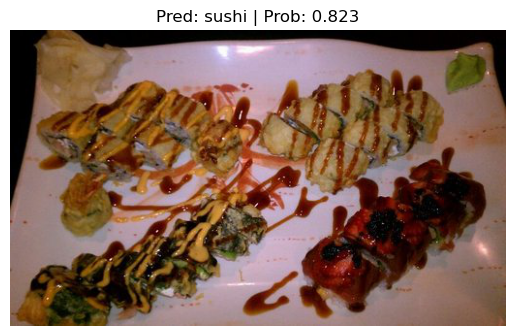

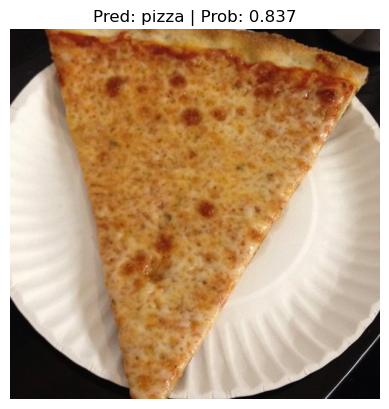

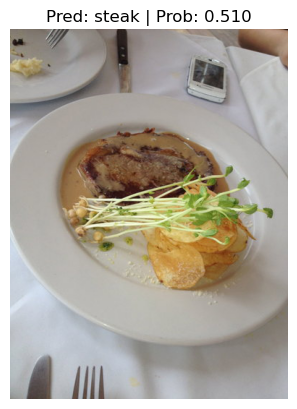

In [76]:
# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_dir / "pizza_steak_sushi_20_percent" / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

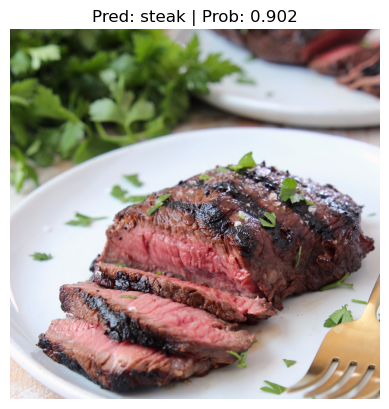

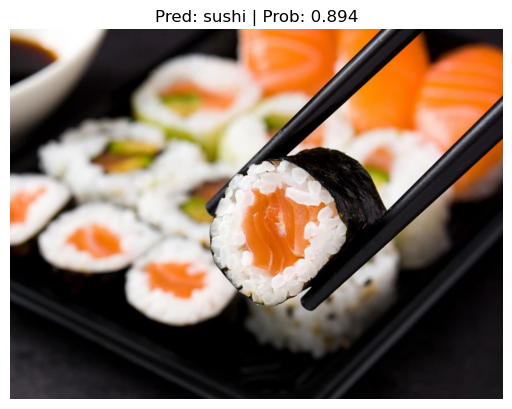

In [77]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=Path("data/custom_image_steak.jpg"),
                    class_names=class_names)

pred_and_plot_image(model=model,
                    image_path=Path("data/custom_image.jpg"),
                    class_names=class_names)
